https://www.freecodecamp.org/news/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d/
https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf
https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/
https://danieltakeshi.github.io/2018/06/28/a2c-a3c/
https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/
https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail/blob/master/a2c_ppo_acktr/algo/a2c_acktr.py
https://github.com/higgsfield/RL-Adventure-2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

In [3]:
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1)
np.random.seed(SEED);
torch.manual_seed(SEED);

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [6]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = test_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [8]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [9]:
LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [10]:
def train(env, policy, optimizer, discount_factor):
    
    policy.train()
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = actor(state)
        value_pred = critic(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward
    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, episode_reward

In [11]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [12]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [13]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):
        
    advantages = advantages.detach()
    returns = returns.detach()
        
    policy_loss = - (advantages * log_prob_actions).sum()
    
    value_loss = F.smooth_l1_loss(returns, values).sum()
        
    optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    optimizer.step()
    
    return policy_loss.item(), value_loss.item()

In [14]:
def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [15]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:  10 | Mean Train Rewards:  32.9 | Mean Test Rewards:  61.6 |
| Episode:  20 | Mean Train Rewards:  40.9 | Mean Test Rewards:  58.7 |
| Episode:  30 | Mean Train Rewards:  62.0 | Mean Test Rewards:  79.6 |
| Episode:  40 | Mean Train Rewards:  71.0 | Mean Test Rewards: 100.3 |
| Episode:  50 | Mean Train Rewards:  91.3 | Mean Test Rewards: 189.6 |
| Episode:  60 | Mean Train Rewards: 109.2 | Mean Test Rewards: 246.8 |
| Episode:  70 | Mean Train Rewards: 131.0 | Mean Test Rewards: 282.8 |
| Episode:  80 | Mean Train Rewards: 143.6 | Mean Test Rewards: 280.5 |
| Episode:  90 | Mean Train Rewards: 179.5 | Mean Test Rewards: 348.7 |
| Episode: 100 | Mean Train Rewards: 233.8 | Mean Test Rewards: 384.7 |
| Episode: 110 | Mean Train Rewards: 312.6 | Mean Test Rewards: 451.6 |
Reached reward threshold in 117 episodes


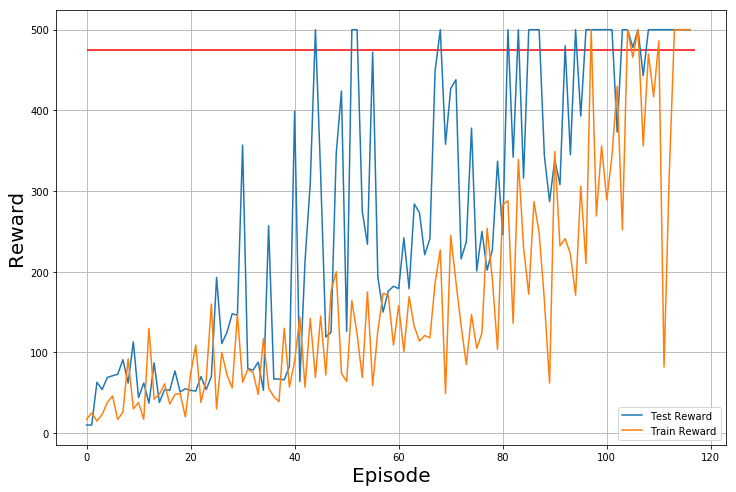

In [16]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()